In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from Common import NetworkList, ModelList, BasisList
from Reconstruction import Reconstruction
from Evaluation import Evaluation

# Parameters

In [2]:
rootDirectory = '/pds/pds11/hoyun/ARNI/data'

#* Network parameter
networkSize = 25
meanDegree = 6
network_cls = NetworkList.ER.value
directed = True

#* Model parameters
model_cls, model_name = ModelList.kuramoto1.value

#* Simulation parameters
length = 10
ensemble = 50
dataDirectory = os.path.join(rootDirectory, model_name)
Path(dataDirectory).mkdir(parents=True, exist_ok=True)


# Simulation

In [3]:
network = network_cls(networkSize, meanDegree)        # Create network instance

#*  Generate network
######################################################
# adjacency = network.getAdjacency(directed)            # Create network (adjacency matrix)
# network.save(dataDirectory)                           # Save adjacency matrix
######################################################


#* Read network
######################################################
adjPath = os.path.join(dataDirectory, 'adjacency.dat')
adjacency = np.loadtxt(adjPath)
adjacency = np.loadtxt('/pds/pds11/hoyun/ARNI/Data/connectivity.dat')
######################################################


In [4]:
model = model_cls(adjacency)                            # Create model instance

#* Generate data
######################################################
# data = model.run(length, ensemble)                      # Run model
# model.save(dataDirectory)                               # Save model time series data
######################################################


#* Read data
######################################################
dataPath = os.path.join(dataDirectory, 'data.npy')
data = np.load(dataPath)
data = np.loadtxt('/pds/pds11/hoyun/ARNI/Data/data.dat')
######################################################


# Reconstruction

In [21]:
######################################################
#* Reconstruction parameters
nodeIdx = 1
basis_cls = BasisList.fourierDiff.value
maxOrder = 6
trueNeighbors = adjacency[nodeIdx]
numNeighbors = np.count_nonzero(trueNeighbors)
trueNeighbors = np.argsort(trueNeighbors)[::-1]
trueNeighbors = trueNeighbors[:numNeighbors]
print(f'True neighbors: {trueNeighbors}')
######################################################

True neighbors: [ 9 20 18 16 11]


## Reconstruct simulation data of nodeIdx with basis

In [22]:
arni = Reconstruction(data, nodeIdx)            # Reconstruction instance is created
dynamics = arni.getDynamics()                   # Dynamics is created from raw data

# Expand dynamics with basis
basis = basis_cls(dynamics, nodeIdx, maxOrder)  # Basis instance is created
basisExpansion = basis.expand()                 # Dynamics is expanded by basis

# Reconstruct interaction with basis expansion
neighbors, adjacencyProb, costArray = arni.reconstruct(basisExpansion)


# Evaluation

In [23]:
print(f'Reconstructed neighbors: {neighbors}')
# print(f'Probability: {[adjacencyProb[neighbors]]}')
print(f'probability: {adjacencyProb}')
print(f'True neighbors: {trueNeighbors}')


Reconstructed neighbors: [ 9 11 18 20 16 15  2 14  5]
probability: [0.         0.         0.01021435 0.         0.         0.00943173
 0.         0.         0.         0.15428919 0.         0.12933864
 0.         0.         0.00981437 0.01078274 0.01240604 0.
 0.10002796 0.         0.05564777 0.         0.         0.
 0.        ]
True neighbors: [ 9 20 18 16 11]


In [24]:
evaluator = Evaluation(adjacency, model)

fpr, tpr, aucScore = evaluator.evaluate(nodeIdx, adjacencyProb)


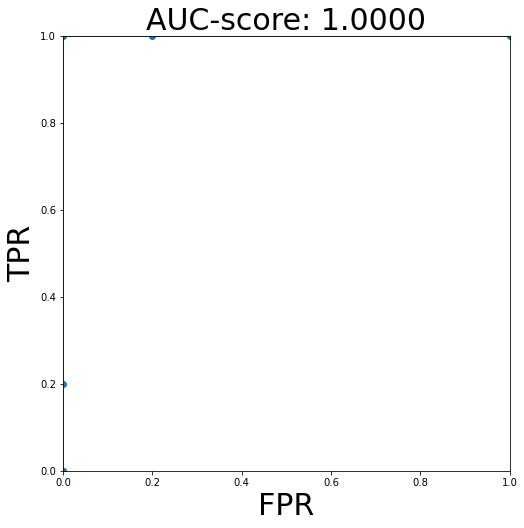

In [25]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr, tpr, 'o-')
ax.set_title(f'AUC-score: {aucScore:.4f}', fontsize=30)
ax.set_xlabel('FPR', fontsize=30)
ax.set_ylabel('TPR', fontsize=30)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

fig.show()

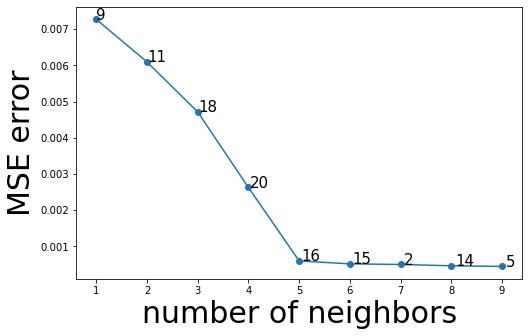

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(np.arange(1, len(costArray)+1), costArray, 'o-')
for i, c in enumerate(costArray):
    ax.text(1+1.01 * i, c, neighbors[i], fontsize=15)

ax.set_xlabel("number of neighbors", fontsize=30)
ax.set_ylabel("MSE error", fontsize=30)

fig.show()